# Image Matching

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen
import cv2
import imutils
import glob
import os
from itertools import accumulate
from utils import download_and_resize_image, resize_image, show_images, image_input_fn, match_images

np.random.seed(10)

In [ ]:
#!pip install scikit-image
#!pip install tensorflow-hub
#!pip install opencv-python
#!pip install imutils

In [24]:
#IMAGE_1_URL = 'https://images.unsplash.com/photo-1522184808165-a39a75502037?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=9058a9f269234b4d7b6dc7bd7066d7e8&auto=format&fit=crop&w=1350&q=80'
#IMAGE_2_URL = 'https://images.unsplash.com/photo-1479660656269-197ebb83b540?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=88b85498e4c076fce0ed0c086543afb6&auto=format&fit=crop&w=1952&q=80'

IMAGE_1_JPG = '3_1.jpg'
IMAGE_2_JPG = '3_2.jpg'

IMAGE_1_URL = './' + IMAGE_1_JPG
IMAGE_2_URL = './' + IMAGE_2_JPG

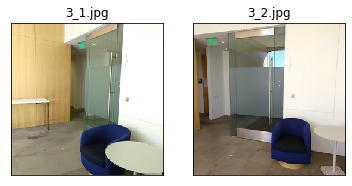

In [25]:
#resize_image(IMAGE_1_URL, IMAGE_1_JPG)
#resize_image(IMAGE_2_URL, IMAGE_2_JPG)
download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

show_images([IMAGE_1_JPG, IMAGE_2_JPG])

In [4]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder, # Image tensor with dtype float32 and shape [height, width, 3]
    'score_threshold': 100.0, # Image features whose attention score exceeds this threshold will be returned
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000, # The maximum number of features that should be returned
}

# Apply the DELF module to the inputs to get the outputs.
module_outputs = m(module_inputs, as_dict=True)

In [26]:
image_tf = image_input_fn([IMAGE_1_JPG, IMAGE_2_JPG])

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        results_dict[image_path] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

# delf_outputs is a dictionary of named tensors:
# * delf_outputs['locations']: a Tensor with dtype float32 and shape [None, 2],
#   where each entry is a coordinate (vertical-offset, horizontal-offset) in
#   pixels from the top-left corner of the image.
# * delf_outputs['descriptors']: a Tensor with dtype float32 and shape
#   [None, 40], where delf_outputs['descriptors'][i] is a 40-dimensional
#   descriptor for the image at location delf_outputs['locations'][i].

Extracting locations and descriptors from 3_1.jpg
Extracting locations and descriptors from 3_2.jpg


Loaded image 1's 89 features
Loaded image 2's 85 features
Found 20 inliers


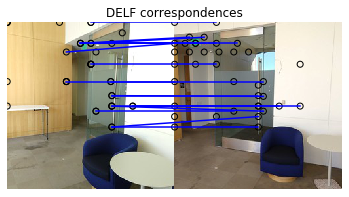

In [27]:
match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)

In [ ]:
import csv
import codecs
building_descs = []
f = codecs.open('./images/buildings.csv', 'rU', encoding='utf-8-sig')
reader = csv.reader(f)
for utf8_row in reader:
    building_descs.append(utf8_row[0])
building_descs

## Resize all database images

In [ ]:
def resize_image(srcfile, destfile, new_width=256, new_height=256):
    pil_image = Image.open(srcfile)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(destfile, format='JPEG', quality=90)
    return destfile
def resize_images_folder(srcfolder, destfolder='./images/resized', new_width=256, new_height=256):
    os.makedirs(destfolder,exist_ok=True)
    for srcfile in glob.iglob(os.path.join('./images/building_images', '*.[Jj][Pp][Gg]')):
        src_basename = os.path.basename(srcfile)
        destfile=os.path.join(destfolder,src_basename)
        resize_image(srcfile, destfile, new_width, new_height)
    return destfolder
def get_resized_db_image_paths(destfolder='./images/resized'):
    return sorted(list(glob.iglob(os.path.join(destfolder, '*.[Jj][Pp][Gg]'))))

In [ ]:
resize_images_folder('./images/building_images')
db_images = get_resized_db_image_paths()

In [ ]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn(db_images)

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    for image_path in db_images:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        results_dict[image_path] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

In [ ]:
def compute_locations_and_descriptors(image_path):
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.FATAL)

    m = hub.Module('https://tfhub.dev/google/delf/1')

    # The module operates on a single image at a time, so define a placeholder to
    # feed an arbitrary image in.
    image_placeholder = tf.placeholder(
        tf.float32, shape=(None, None, 3), name='input_image')

    module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }

    module_outputs = m(module_inputs, as_dict=True)

    image_tf = image_input_fn([image_path])

    with tf.train.MonitoredSession() as sess:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        return sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

### Aggregate all database images' locations and descriptors to lists
Calculate accumulated/aggregated indexes boundaries per image so we can reverse search the image index given an accumulated/aggregated index.

In [ ]:
locations_agg = np.concatenate([results_dict[img][0] for img in db_images])
descriptors_agg = np.concatenate([results_dict[img][1] for img in db_images])
accumulated_indexes_boundaries = list(accumulate([results_dict[img][0].shape[0] for img in db_images]))

### Build KD tree with database images' descriptors

In [ ]:
d_tree = cKDTree(descriptors_agg) # build the KD tree

## Query a new image

In [ ]:
query_image = './images/query_buildings/q1.jpg'
def preprocess_query_image(imagepath):
    '''
    Resize the query image and return the resized image path.
    '''
    query_temp_folder_name = 'query_temp_folder'
    query_temp_folder = os.path.join(os.path.dirname(query_image), query_temp_folder_name)
    os.makedirs(query_temp_folder,exist_ok=True)
    query_basename = os.path.basename(query_image)
    destfile=os.path.join(query_temp_folder,query_basename)
    resized_image = resize_image(query_image, destfile)
    return resized_image

resized_image = preprocess_query_image(query_image)

In [ ]:
query_image_locations, query_image_descriptors = compute_locations_and_descriptors(resized_image)

### Query the KD tree to find K nearest neighbors for each descriptor

In [ ]:
distance_threshold = 0.8
# K nearest neighbors
K = 10
distances, indices = d_tree.query(
    query_image_descriptors, distance_upper_bound=distance_threshold, k = K, n_jobs=-1)

# Find the list of unique accumulated/aggregated indexes
unique_indices = np.array(list(set(indices.flatten())))

unique_indices.sort()
if unique_indices[-1] == descriptors_agg.shape[0]:
    unique_indices = unique_indices[:-1]

## Get a list of database candidate image indexes
Look up a list of unique image indexes, each image contains at least one of K nearest neighbor result descriptors.
By reverse indexes look up.

In [ ]:
unique_image_indexes = np.array(
    list(set([np.argmax([np.array(accumulated_indexes_boundaries)>index]) 
              for index in unique_indices])))
unique_image_indexes

In [ ]:
def image_index_2_accumulated_indexes(index, accumulated_indexes_boundaries):
    '''
    Image index to accumulated/aggregated locations/descriptors pair indexes.
    '''
    if index > len(accumulated_indexes_boundaries) - 1:
        return None
    accumulated_index_start = None
    accumulated_index_end = None
    if index == 0:
        accumulated_index_start = 0
        accumulated_index_end = accumulated_indexes_boundaries[index]
    else:
        accumulated_index_start = accumulated_indexes_boundaries[index-1]
        accumulated_index_end = accumulated_indexes_boundaries[index]
    return np.arange(accumulated_index_start,accumulated_index_end)

In [ ]:
def get_locations_2_use(image_db_index, k_nearest_indices, accumulated_indexes_boundaries):
    '''
    Get a pair of locations to use, the query image to the database image with given index.
    Return: a tuple of 2 numpy arrays, the locations pair.
    '''
    image_accumulated_indexes = image_index_2_accumulated_indexes(image_db_index, accumulated_indexes_boundaries)
    locations_2_use_query = []
    locations_2_use_db = []
    for i, row in enumerate(k_nearest_indices):
        for acc_index in row:
            if acc_index in image_accumulated_indexes:
                locations_2_use_query.append(query_image_locations[i])
                locations_2_use_db.append(locations_agg[acc_index])
                break
    return np.array(locations_2_use_query), np.array(locations_2_use_db)
            

### Perform geometric verification using RANSAC and visualization

In [ ]:
# Array to keep track of all candidates in database.
inliers_counts = []
# Read the resized query image for plotting.
img_1 = mpimg.imread(resized_image)
for index in unique_image_indexes:
    locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
    # Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_2_use_db, locations_2_use_query), # source and destination coordinates
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=1000)
    # If no inlier is found for a database candidate image, we continue on to the next one.
    if inliers is None or len(inliers) == 0:
        continue
    # the number of inliers as the score for retrieved images.
    inliers_counts.append({"index": index, "inliers": sum(inliers)})
    print('Found inliers for image {} -> {}'.format(index, sum(inliers)))
    # Visualize correspondences.
    _, ax = plt.subplots()
    img_2 = mpimg.imread(db_images[index])
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
        ax,
        img_1,
        img_2,
        locations_2_use_db,
        locations_2_use_query,
        np.column_stack((inlier_idxs, inlier_idxs)),
        matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.show()

In [ ]:
inliers_counts

### Show the top match result
Employ the number of inliers as the score for retrieved images.

In [ ]:
top_match = sorted(inliers_counts, key=lambda k: k['inliers'], reverse=True)[0]

index = top_match['index']
print('Best guess for this image:', building_descs[index])
locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
# Perform geometric verification using RANSAC.
_, inliers = ransac(
    (locations_2_use_db, locations_2_use_query), # source and destination coordinates
    AffineTransform,
    min_samples=3,
    residual_threshold=20,
    max_trials=1000)
# Visualize correspondences.
_, ax = plt.subplots()
img_2 = mpimg.imread(db_images[index])
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
    ax,
    img_1,
    img_2,
    locations_2_use_db,
    locations_2_use_query,
    np.column_stack((inlier_idxs, inlier_idxs)),
    matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame(np.unique(locations_agg, axis=0), columns=['x', 'y'])
df.head()

In [ ]:
fig, axe = plt.subplots(ncols=1, figsize = (6,6))
df.plot.scatter(x = 'x', y='y', fontsize=15, ax = axe)
axe.set_ylabel("y", size = 20)
axe.set_xlabel("x", size = 20)
plt.show()

In [ ]:
np.array(accumulated_indexes_boundaries)